In [17]:
# Cell 1 (MODIFIED): Import necessary libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import os
import glob
from datetime import datetime

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Force CPU usage to avoid CUDA errors
device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cpu


In [18]:
# Cell 2: Custom Dataset Class

class QuickDrawDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the class folders (e.g., 'selected_images/')
            transform (callable, optional): Optional transform to be applied on images
        """
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_names = []
        
        # Get all class folders
        class_folders = sorted([d for d in os.listdir(root_dir) 
                               if os.path.isdir(os.path.join(root_dir, d))])
        
        self.class_names = class_folders
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(class_folders)}
        
        # Load all image paths and labels
        for class_name in class_folders:
            class_folder = os.path.join(root_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            
            # Get all PNG images in this class folder
            image_files = glob.glob(os.path.join(class_folder, '*.png'))
            
            for img_path in image_files:
                self.images.append(img_path)
                self.labels.append(class_idx)
        
        print(f'Loaded {len(self.images)} images from {len(self.class_names)} classes')
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        
        # Load image
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        
        # Apply transforms if any
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [19]:
# Cell 3: Define transforms and load dataset

# Define transformations for the images
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor (0-1 range)
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] range
])

# Load the full dataset
data_dir = '../data/'  # Update this path if needed
full_dataset = QuickDrawDataset(root_dir=data_dir, transform=transform)

print(f'Number of classes: {len(full_dataset.class_names)}')
print(f'Total images: {len(full_dataset)}')

Loaded 9900 images from 100 classes
Number of classes: 100
Total images: 9900


In [20]:
# Cell 4: Split dataset into train and test sets

# 80-20 split
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(
    full_dataset, 
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

print(f'Training set size: {len(train_dataset)}')
print(f'Test set size: {len(test_dataset)}')

Training set size: 7920
Test set size: 1980


In [21]:
# Cell 5: Create DataLoaders

batch_size = 128

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    num_workers=2  # Adjust based on your system
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=2
)

print(f'Number of training batches: {len(train_loader)}')
print(f'Number of test batches: {len(test_loader)}')

Number of training batches: 62
Number of test batches: 16


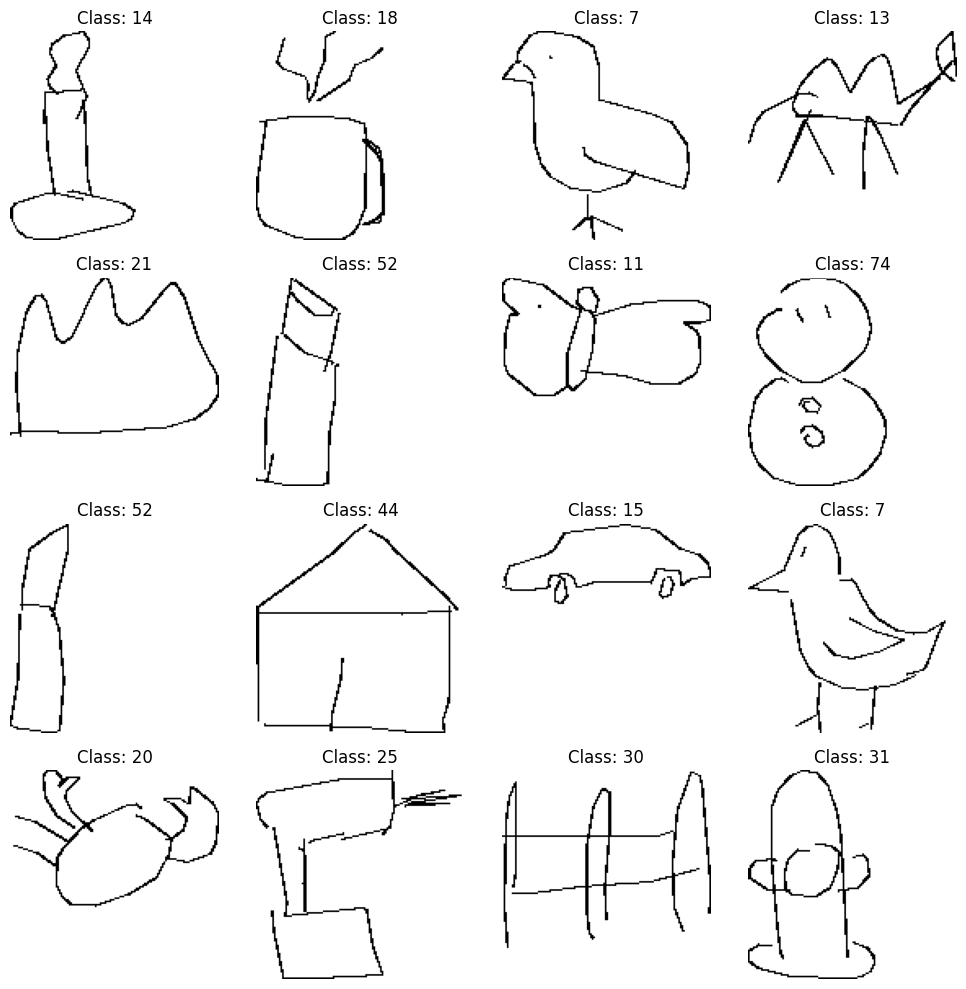

In [22]:
# Cell 6: Visualize some sample images (optional but helpful)

# Get a batch of training data
images, labels = next(iter(train_loader))

# Plot first 16 images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    if i < len(images):
        # Denormalize and display
        img = images[i].squeeze().cpu().numpy()
        img = (img * 0.5) + 0.5  # Reverse normalization
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Class: {labels[i].item()}')
        ax.axis('off')

plt.tight_layout()
plt.show()

In [23]:
# Cell 7 (FIXED): Define CNN Architecture with Adaptive Pooling

class QuickDrawCNN(nn.Module):
    def __init__(self, num_classes=100):
        super(QuickDrawCNN, self).__init__()
        
        # Convolutional Block 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Convolutional Block 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Convolutional Block 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        
        # Adaptive pooling to ensure fixed output size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        # Fully Connected Layers
        # After adaptive pooling: 128 channels * 4 * 4 = 2048
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        # Convolutional layers
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.relu3(self.conv3(x))
        
        # Adaptive pooling to fixed size
        x = self.adaptive_pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.relu4(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# CNN Architecture Explanation

## Model Overview

This CNN architecture is designed specifically for the QuickDraw dataset, which consists of 28×28 grayscale images across 100 classes. The model follows a classic convolutional neural network design with three convolutional blocks followed by fully connected layers.

---

## Architecture Details

### Input Layer
- **Input Shape**: 28×28×1 (grayscale images)
- **Preprocessing**: Images are normalized to the range [-1, 1]

---

### Convolutional Block 1
- **Conv2d Layer**: 1 input channel → 32 output channels
  - Kernel size: 3×3
  - Padding: 1 (preserves spatial dimensions)
- **Activation**: ReLU (Rectified Linear Unit)
- **MaxPooling**: 2×2 with stride 2
- **Output Shape**: 14×14×32

**Purpose**: Detects basic features like edges, lines, and simple shapes

---

### Convolutional Block 2
- **Conv2d Layer**: 32 input channels → 64 output channels
  - Kernel size: 3×3
  - Padding: 1
- **Activation**: ReLU
- **MaxPooling**: 2×2 with stride 2
- **Output Shape**: 7×7×64

**Purpose**: Combines basic features into more complex patterns (curves, corners, parts of objects)

---

### Convolutional Block 3
- **Conv2d Layer**: 64 input channels → 128 output channels
  - Kernel size: 3×3
  - Padding: 1
- **Activation**: ReLU
- **MaxPooling**: 2×2 with stride 2
- **Output Shape**: 3×3×128

**Purpose**: Learns high-level abstract features specific to each class

---

### Fully Connected Layers

**Flatten Layer**
- Converts 3D feature maps to 1D vector
- Output: 128 × 3 × 3 = 1152 features

**FC1 (First Dense Layer)**
- Input: 1152 features
- Output: 256 neurons
- **Activation**: ReLU
- **Dropout**: 0.5 (randomly drops 50% of neurons during training to prevent overfitting)

**FC2 (Output Layer)**
- Input: 256 features
- Output: 100 neurons (one per class)
- **No activation here** (will use CrossEntropyLoss which applies softmax internally)

---

## Design Choices & Rationale

### 1. **Three Convolutional Layers**
   - Provides sufficient depth to learn hierarchical features
   - Not too deep to cause vanishing gradients or excessive computation
   - Appropriate for 28×28 input resolution

### 2. **Increasing Filter Sizes (32 → 64 → 128)**
   - Early layers capture simple features with fewer filters
   - Deeper layers need more filters to represent complex patterns
   - Standard practice in CNN design

### 3. **3×3 Kernel Size with Padding**
   - Small receptive field that's computationally efficient
   - Padding=1 preserves spatial dimensions before pooling
   - Proven effective in modern architectures (VGG, ResNet)

### 4. **MaxPooling (2×2)**
   - Reduces spatial dimensions by half at each stage
   - Provides translation invariance
   - Reduces computational cost and parameters
   - Helps prevent overfitting

### 5. **ReLU Activation**
   - Computationally efficient (simple thresholding)
   - Helps avoid vanishing gradient problem
   - Introduces non-linearity for learning complex patterns

### 6. **Dropout (0.5)**
   - Regularization technique to prevent overfitting
   - Randomly drops 50% of neurons during training
   - Forces network to learn robust features
   - Only applied during training, disabled during evaluation

### 7. **256 Hidden Units in FC1**
   - Balances between model capacity and overfitting risk
   - Sufficient to combine features for 100-class classification
   - Not too large to cause excessive parameters

---

## Total Parameters

The model has approximately **500K-600K trainable parameters**, which is:
- ✅ Large enough to learn complex patterns
- ✅ Small enough to train efficiently
- ✅ Appropriate for the dataset size

---

## Expected Behavior

- **Early Layers**: Learn edges, textures, and basic shapes
- **Middle Layers**: Detect curves, corners, and object parts
- **Late Layers**: Recognize complete object features
- **FC Layers**: Combine all features for final classification

This architecture strikes a good balance between model capacity, training efficiency, and generalization ability.

In [24]:
# Cell 8 (NEW): Create Model Instance - RUN THIS AFTER CELL 7

# IMPORTANT: Delete the old model first
if 'model' in globals():
    del model
    
# Create new model instance
model = QuickDrawCNN(num_classes=100).to(device)

# Print model summary
print(model)
print(f'\nTotal parameters: {sum(p.numel() for p in model.parameters())}')

# Test with a dummy input to verify it works
test_input = torch.randn(1, 1, 28, 28).to(device)
test_output = model(test_input)
print(f'\nTest successful! Output shape: {test_output.shape}')

QuickDrawCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(4, 4))
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=100, bias=True)
)

Total parameters: 642916

Test successful! Output shape: torch.Size([1, 100])


In [25]:
# Cell 9 (RERUN): Define Loss Function and Optimizer

# Loss function for multi-class classification
criterion = nn.CrossEntropyLoss()

# Optimizer - Adam is a good default choice
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f'Loss Function: CrossEntropyLoss')
print(f'Optimizer: Adam')
print(f'Learning Rate: {learning_rate}')

Loss Function: CrossEntropyLoss
Optimizer: Adam
Learning Rate: 0.001


In [26]:
# Cell 10: Training and Evaluation Functions

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train the model for one epoch
    Returns: average loss and accuracy for the epoch
    """
    model.train()  # Set model to training mode
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        # Move data to device
        images, labels = images.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Calculate statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc


def evaluate(model, test_loader, criterion, device):
    """
    Evaluate the model on test/validation set
    Returns: average loss and accuracy
    """
    model.eval()  # Set model to evaluation mode
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradient calculation needed
        for images, labels in test_loader:
            # Move data to device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Calculate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(test_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

In [49]:
# Cell 11: Training Loop with Metric Tracking

# Hyperparameters
num_epochs = 10

# Lists to store metrics for plotting
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

print('Starting Training...\n')
now = datetime.now()
print(now.strftime("%H:%M:%S"))
print('=' * 70)

for epoch in range(num_epochs):
    # Train for one epoch
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    
    # Evaluate on test set
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    # Print progress
    now = datetime.now()
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'  Test Loss:  {test_loss:.4f} | Test Acc:  {test_acc:.2f}%')
    print(now.strftime("%H:%M:%S"))
    print('-' * 70)

print('\nTraining Complete!')
print(f'Final Test Accuracy: {test_accuracies[-1]:.2f}%')

Starting Training...

22:15:27
Epoch [1/10]
  Train Loss: 0.7155 | Train Acc: 79.12%
  Test Loss:  0.3268 | Test Acc:  90.66%
22:17:38
----------------------------------------------------------------------
Epoch [2/10]
  Train Loss: 0.5642 | Train Acc: 83.86%
  Test Loss:  0.2676 | Test Acc:  92.42%
22:19:49
----------------------------------------------------------------------
Epoch [3/10]
  Train Loss: 0.4853 | Train Acc: 85.52%
  Test Loss:  0.2346 | Test Acc:  92.83%
22:22:12
----------------------------------------------------------------------
Epoch [4/10]
  Train Loss: 0.4049 | Train Acc: 87.69%
  Test Loss:  0.2138 | Test Acc:  94.14%
22:24:37
----------------------------------------------------------------------
Epoch [5/10]
  Train Loss: 0.3745 | Train Acc: 88.62%
  Test Loss:  0.2126 | Test Acc:  93.64%
22:26:53
----------------------------------------------------------------------
Epoch [6/10]
  Train Loss: 0.3378 | Train Acc: 89.86%
  Test Loss:  0.1897 | Test Acc:  94.14%

In [50]:
# Cell 12: Display Training Summary

print('Training Summary')
print('=' * 70)
print(f'Number of Epochs: {num_epochs}')
print(f'Batch Size: {batch_size}')
print(f'Learning Rate: {learning_rate}')
print(f'Optimizer: Adam')
print(f'Loss Function: CrossEntropyLoss')
print('=' * 70)
print(f'\nInitial Test Accuracy: {test_accuracies[0]:.2f}%')
print(f'Final Test Accuracy: {test_accuracies[-1]:.2f}%')
print(f'Improvement: {test_accuracies[-1] - test_accuracies[0]:.2f}%')
print(f'\nBest Test Accuracy: {max(test_accuracies):.2f}% (Epoch {test_accuracies.index(max(test_accuracies))+1})')

Training Summary
Number of Epochs: 10
Batch Size: 128
Learning Rate: 0.001
Optimizer: Adam
Loss Function: CrossEntropyLoss

Initial Test Accuracy: 90.66%
Final Test Accuracy: 94.80%
Improvement: 4.14%

Best Test Accuracy: 95.20% (Epoch 9)


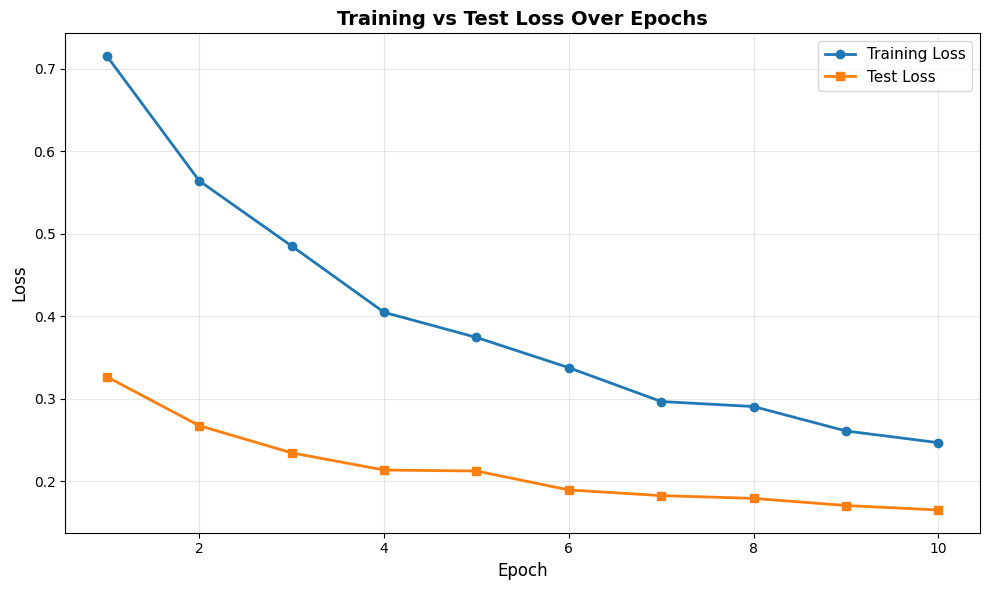

In [51]:
# Cell 13: Plot Training vs Test Loss

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o', linewidth=2)
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', marker='s', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training vs Test Loss Over Epochs', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

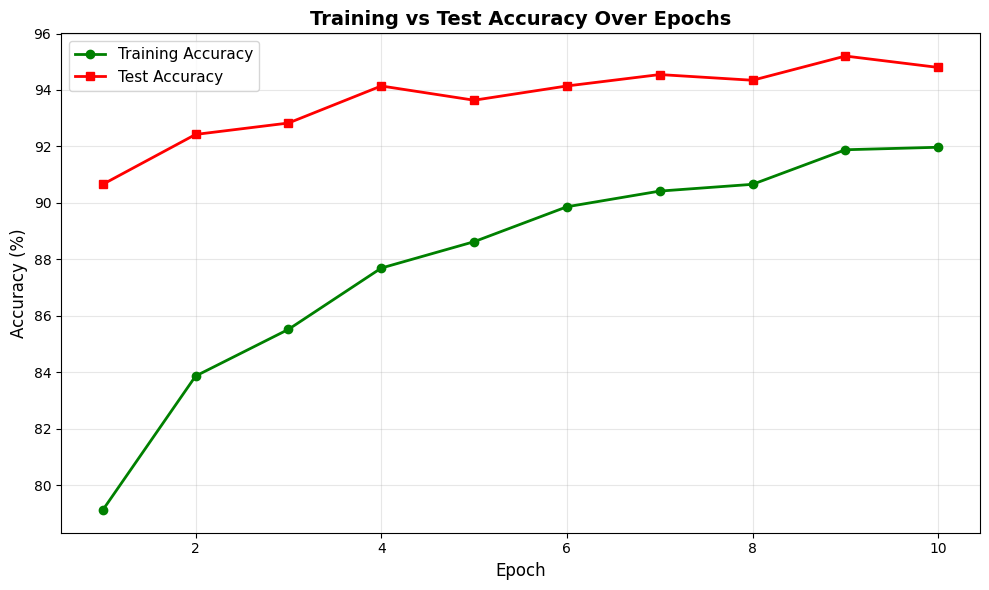

In [52]:
# Cell 14: Plot Training vs Test Accuracy

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', marker='o', linewidth=2, color='green')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', marker='s', linewidth=2, color='red')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Training vs Test Accuracy Over Epochs', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

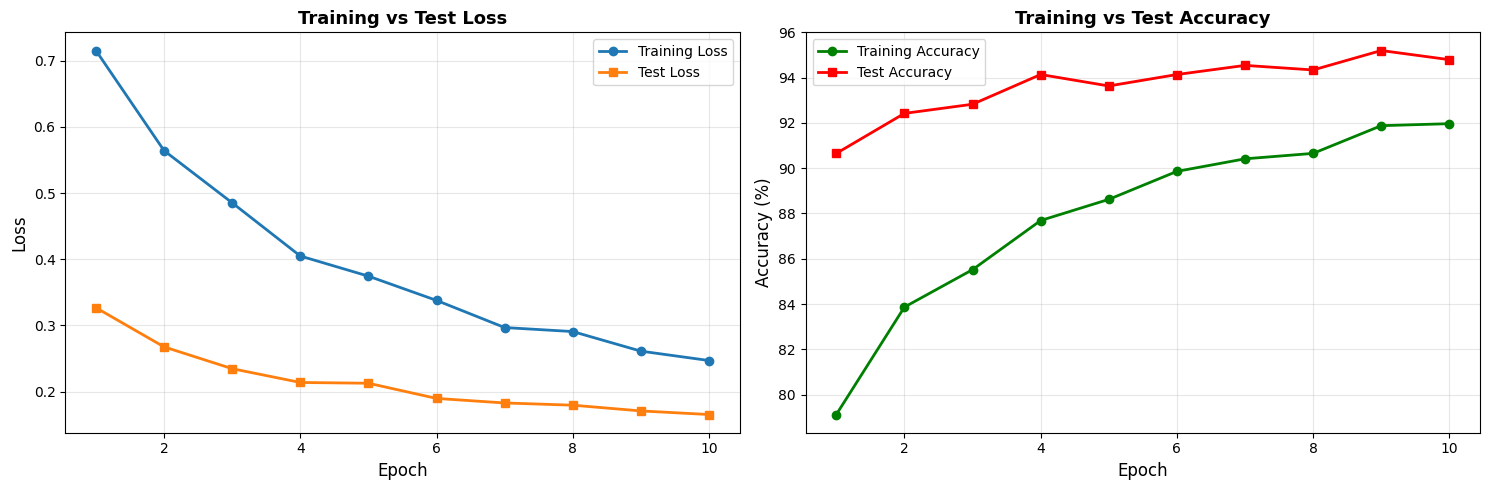

In [54]:
# Cell 15: Combined Plot (Optional - looks nice for reports!)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o', linewidth=2)
ax1.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', marker='s', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training vs Test Loss', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', marker='o', linewidth=2, color='green')
ax2.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', marker='s', linewidth=2, color='red')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training vs Test Accuracy', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

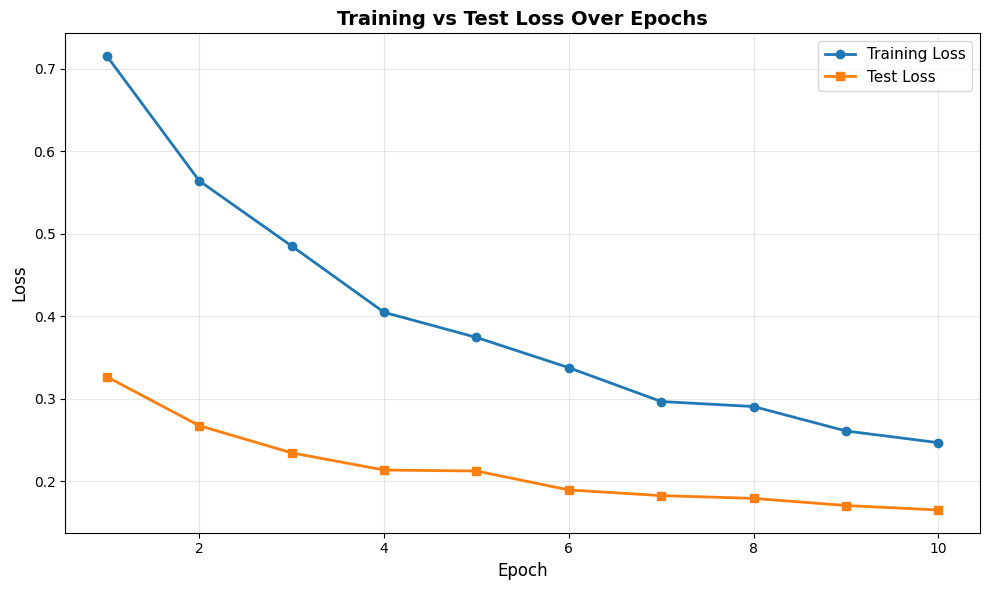

Loss plot saved as: loss_plot.png


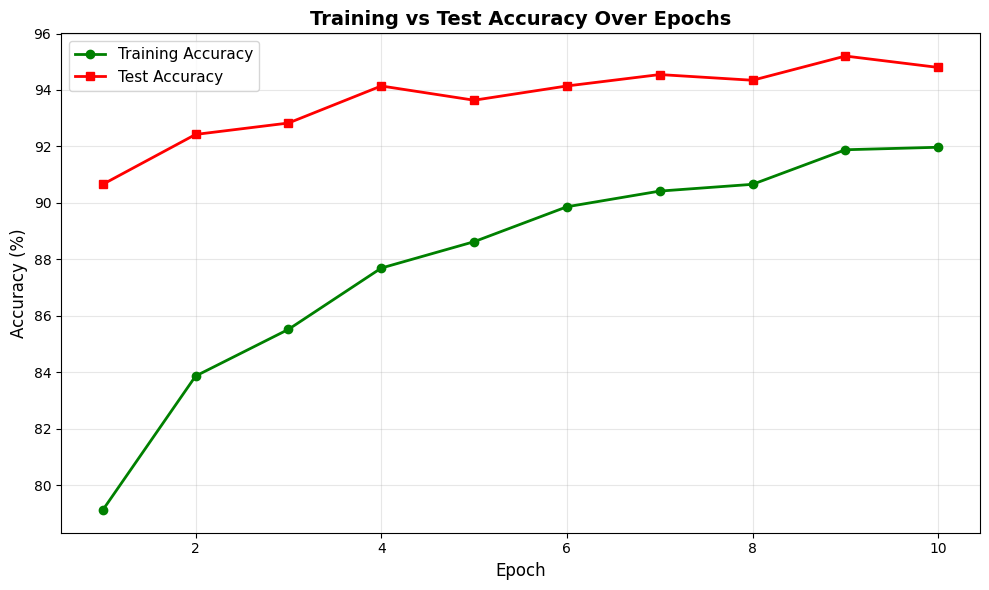

Accuracy plot saved as: accuracy_plot.png


In [55]:
# Cell 16: Save Plots as Images (for your PDF report)

# Save Loss plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o', linewidth=2)
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', marker='s', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training vs Test Loss Over Epochs', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('loss_plot.png', dpi=300, bbox_inches='tight')
plt.show()
print('Loss plot saved as: loss_plot.png')

# Save Accuracy plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', marker='o', linewidth=2, color='green')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', marker='s', linewidth=2, color='red')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Training vs Test Accuracy Over Epochs', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('accuracy_plot.png', dpi=300, bbox_inches='tight')
plt.show()
print('Accuracy plot saved as: accuracy_plot.png')

In [56]:
# Cell 17: Save the Trained Model

# Save the model state dictionary
model_path = 'model.pth'
torch.save(model.state_dict(), model_path)

print(f'Model saved successfully to: {model_path}')
print(f'File size: {os.path.getsize(model_path) / (1024 * 1024):.2f} MB')

Model saved successfully to: model.pth
File size: 2.46 MB


In [57]:
# Cell 18: Verify the Model was Saved Correctly

# Check if file exists
if os.path.exists(model_path):
    print(f'✓ Model file exists: {model_path}')
    
    # Load the model to verify it works
    checkpoint = torch.load(model_path, map_location=device)
    print(f'✓ Model loaded successfully')
    print(f'✓ Number of parameters in saved model: {len(checkpoint)}')
else:
    print(f'✗ Error: Model file not found at {model_path}')

✓ Model file exists: model.pth
✓ Model loaded successfully
✓ Number of parameters in saved model: 10


In [58]:
# Cell 19: Load the Saved Model

# Define the model architecture again (same as before)
loaded_model = QuickDrawCNN(num_classes=100).to(device)

# Load the saved weights
loaded_model.load_state_dict(torch.load('model.pth', map_location=device))

# Set to evaluation mode
loaded_model.eval()

print('✓ Model loaded successfully from: src/model.pth')
print(f'✓ Model is on device: {next(loaded_model.parameters()).device}')
print(f'✓ Total parameters: {sum(p.numel() for p in loaded_model.parameters())}')

✓ Model loaded successfully from: src/model.pth
✓ Model is on device: cpu
✓ Total parameters: 642916


In [59]:
# Cell 20: Evaluate Loaded Model on Test Set

print('Evaluating loaded model on test set...')
print('=' * 70)

# Use the evaluate function we defined earlier
final_test_loss, final_test_acc = evaluate(loaded_model, test_loader, criterion, device)

print(f'\nFinal Test Results:')
print(f'  Test Loss: {final_test_loss:.4f}')
print(f'  Test Accuracy: {final_test_acc:.2f}%')
print('=' * 70)

Evaluating loaded model on test set...

Final Test Results:
  Test Loss: 0.1654
  Test Accuracy: 94.80%


In [60]:
# Cell 21: Detailed Evaluation Statistics

print('Detailed Evaluation Statistics')
print('=' * 70)

loaded_model.eval()

all_predictions = []
all_labels = []
correct_per_class = {}
total_per_class = {}

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = loaded_model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Count correct predictions per class
        for label, pred in zip(labels.cpu().numpy(), predicted.cpu().numpy()):
            if label not in total_per_class:
                total_per_class[label] = 0
                correct_per_class[label] = 0
            
            total_per_class[label] += 1
            if label == pred:
                correct_per_class[label] += 1

# Calculate overall statistics
total_samples = len(all_labels)
correct_samples = sum(correct_per_class.values())

print(f'Total test samples: {total_samples}')
print(f'Correctly classified: {correct_samples}')
print(f'Incorrectly classified: {total_samples - correct_samples}')
print(f'Overall accuracy: {100 * correct_samples / total_samples:.2f}%')
print('=' * 70)

# Show accuracy for first 10 classes as example
print('\nSample Per-Class Accuracy (first 10 classes):')
for class_idx in sorted(total_per_class.keys())[:10]:
    class_acc = 100 * correct_per_class[class_idx] / total_per_class[class_idx]
    class_name = full_dataset.class_names[class_idx]
    print(f'  Class {class_idx:2d} ({class_name:15s}): {class_acc:.2f}% ({correct_per_class[class_idx]}/{total_per_class[class_idx]})')

Detailed Evaluation Statistics
Total test samples: 1980
Correctly classified: 1877
Incorrectly classified: 103
Overall accuracy: 94.80%

Sample Per-Class Accuracy (first 10 classes):
  Class  0 (ambulance      ): 100.00% (16/16)
  Class  1 (angel          ): 95.24% (20/21)
  Class  2 (apple          ): 89.47% (17/19)
  Class  3 (bandage        ): 95.00% (19/20)
  Class  4 (baseball       ): 50.00% (7/14)
  Class  5 (bee            ): 100.00% (17/17)
  Class  6 (binoculars     ): 95.45% (21/22)
  Class  7 (bird           ): 100.00% (19/19)
  Class  8 (book           ): 91.30% (21/23)
  Class  9 (bracelet       ): 100.00% (17/17)


In [61]:
# Cell 22: Verify Model Reproducibility

print('Verifying Model Reproducibility...')
print('=' * 70)

# Compare original model with loaded model on a few test batches
original_model = model  # The model we trained
loaded_model.eval()
original_model.eval()

test_batch_images, test_batch_labels = next(iter(test_loader))
test_batch_images = test_batch_images.to(device)

with torch.no_grad():
    outputs_original = original_model(test_batch_images)
    outputs_loaded = loaded_model(test_batch_images)
    
    # Check if outputs are identical
    if torch.allclose(outputs_original, outputs_loaded, rtol=1e-5):
        print('✓ SUCCESS: Loaded model produces identical outputs to original model')
        print('✓ Model is fully reproducible')
    else:
        print('✗ WARNING: Outputs differ slightly (this might be okay due to floating point precision)')

print('=' * 70)

Verifying Model Reproducibility...
✓ SUCCESS: Loaded model produces identical outputs to original model
✓ Model is fully reproducible
